# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
from pathlib import Path

from PIL import Image
from google import genai

import tt

LOG = logging.getLogger(__name__)
tt.logging_init()

# logging.root.manager.loggerDict
logging.getLogger("google_genai").setLevel(logging.WARNING)
logging.getLogger("httpx").setLevel(logging.WARNING)

In [3]:
CATEGORIES = [
    "chicken",
    "cow",
    "creeper",
    "enderman",
    "pig",
    "sheep",
    "skeleton",
    "spider",
    "zombie",
]
CATEGORIES.sort()
CATEGORIES_MINECRAFT = [f"minecraft {x}" for x in CATEGORIES]

flash = "gemini-2.5-flash"
flash_lite = "gemini-2.5-flash-lite"
prompt_short = f"""Detect {", ".join(CATEGORIES)}. Return AT MOST 20 detections."""

mobs_path = Path.home() / "src/data/mobs2"
images_path = mobs_path / "640"

QCFG = tt.GeminiQueryConfig(prompt=prompt_short, categories=CATEGORIES)

# File upload

In [4]:
GF = tt.GeminiFileAPI()
# GF.clear()
# GF.upload_dir(images_path, slice_obj=slice(None))
GF.sync()
print(f"n_files={len(GF.gfiles)}")
print(GF.gfiles)

n_files=139
[File(
  create_time=datetime.datetime(2025, 11, 15, 2, 40, 53, 339774, tzinfo=TzInfo(0)),
  display_name='/Users/joe/src/data/mobs2/640/frame_9807.png',
  expiration_time=datetime.datetime(2025, 11, 17, 2, 40, 53, 65117, tzinfo=TzInfo(0)),
  mime_type='image/png',
  name='files/8majz2y9mzz0',
  sha256_hash='Mjc0ZDcyY2FkZjVhY2FhZjJkZjA5NDIzZTVlNWMwOWJkZGNkMDQ0ZTdjOWEzODU4YTkxMGExMWU4ZjYyYTNlMw==',
  size_bytes=392333,
  source=<FileSource.UPLOADED: 'UPLOADED'>,
  state=<FileState.ACTIVE: 'ACTIVE'>,
  update_time=datetime.datetime(2025, 11, 15, 2, 40, 53, 339774, tzinfo=TzInfo(0)),
  uri='https://generativelanguage.googleapis.com/v1beta/files/8majz2y9mzz0'
), File(
  create_time=datetime.datetime(2025, 11, 15, 2, 40, 51, 994092, tzinfo=TzInfo(0)),
  display_name='/Users/joe/src/data/mobs2/640/frame_9191.png',
  expiration_time=datetime.datetime(2025, 11, 17, 2, 40, 51, 739966, tzinfo=TzInfo(0)),
  mime_type='image/png',
  name='files/6h5jequpw5ed',
  sha256_hash='OWE5NDY0ODd

# 

# Detect

In [ ]:
# This image causes gemini-2.5-flash-lite to detect the pig repeatedly.
image_break = "/Users/joe/src/data/mobs1/640/cda62cfe-2024-10-20_22.22.31.png"
image640 = Image.open(image_break)
# display(image640)
bbox = tt.gemini_gen_bboxes(image640, QCFG)
print(bbox)
display(tt.plot_bb(image640, bbox, CATEGORIES))

In [ ]:
# This causes gemini to identify a bunch of ice blocks
image_break = "/Users/joe/src/data/mobs2/640/frame_10835.png"
image640 = Image.open(image_break)
# display(image640)
bbox = tt.gemini_detect_gfile(image640, QCFG)
print(bbox)
display(tt.plot_bb(image640, bbox, CATEGORIES))

[19:44:31]:[INFO]:(tt): Response len=58 [
  {"box_2d": [156, 558, 290, 699], "label": "chicken"}
]


[BBox(category='chicken', xyxyn=[0.558, 0.156, 0.699, 0.29])]


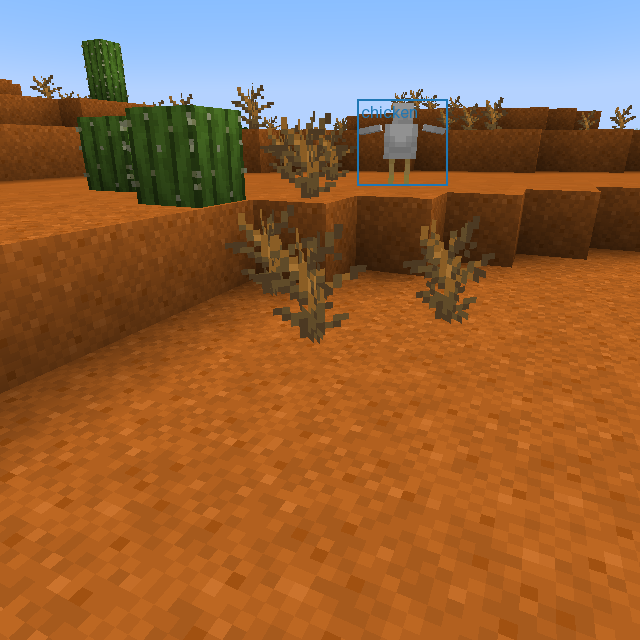

In [5]:
# Test single query
image640 = Image.open(sorted(images_path.glob("*.png"))[5])
bbox = tt.gemini_detect_single(image640, QCFG)
print(bbox)
display(tt.plot_bb(image640, bbox, CATEGORIES))

In [ ]:
# Display results of one query at a time
def detect_single(gfile: genai.types.File):
    return tt.gemini_detect_gfile(gfile, QCFG)
tt.InferViewer[genai.types.File](detect_single, GF.gfiles, QCFG.categories).show_widget()

In [6]:
# Run all queries first, then display the results
# GFILES10 = GF.gfiles[:10]
# results = tt.gemini_detect_gfile_multi(GFILES10, QCFG)
results = tt.gemini_detect_gfile_multi(GF.gfiles, QCFG)
tt.InferViewer[tt.ImageResult](lambda x: x, results, QCFG.categories).show_widget()

[19:44:40]:[INFO]:(tt): Detect index=0 len=139 file=/Users/joe/src/data/mobs2/640/frame_9807.png
[19:44:40]:[INFO]:(tt): Query-Attempt-1
[19:44:43]:[INFO]:(tt): Response len=110 [
  {"box_2d": [349, 553, 400, 607], "label": "chicken"},
  {"box_2d": [395, 279, 426, 305], "label": "cow"}
]
[19:44:43]:[INFO]:(tt): Detect index=1 len=139 file=/Users/joe/src/data/mobs2/640/frame_9191.png
[19:44:43]:[INFO]:(tt): Query-Attempt-1
[19:44:44]:[INFO]:(tt): Response len=58 [
  {"box_2d": [370, 627, 438, 714], "label": "chicken"}
]
[19:44:44]:[INFO]:(tt): Detect index=2 len=139 file=/Users/joe/src/data/mobs2/640/frame_90308.png
[19:44:44]:[INFO]:(tt): Query-Attempt-1
[19:44:46]:[INFO]:(tt): Response len=59 [
  {"box_2d": [298, 290, 600, 420], "label": "skeleton"}
]
[19:44:46]:[INFO]:(tt): Detect index=3 len=139 file=/Users/joe/src/data/mobs2/640/frame_89749.png
[19:44:46]:[INFO]:(tt): Query-Attempt-1
[19:44:47]:[INFO]:(tt): Response len=59 [
  {"box_2d": [375, 427, 629, 527], "label": "skeleton"}
]

interactive(children=(IntSlider(value=0, continuous_update=False, description='Image:', max=138), Output()), _…

In [7]:
dset = tt.Dataset(categories=QCFG.categories, images=results)
dset.save(mobs_path / "gemini_results.json")